In [7]:
import numpy as np
import pandas as pd
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt

from tqdm import tqdm

import utils

### Track Data

For our training data, we sample tracks from the barrel region of the detector. Each track must also span at least 6 unique detector layers. To discretize our detector space, we work with detector modules of each hit instead of its x,y,z coords. In this study, our vocabulary consists of 14000 detector modules + 2 custom tokens. These custom tokens are SOS (denotes the start of a track) and SEP (denotes the end of a track)

The file ```./data.pickle``` contains a list of dataframes. Each dataframe contains all the module hits in an example track. For each hit, the dataframe position information as well as its unique module idx (**um_idx**) and its unique module id (**umid**)
Let's load these tracks visualize them below

In [2]:
with open("./data.pickle", 'rb') as handle:
    tracks = pickle.load(handle)
track_keys = list(tracks.keys())
print("All track keys:")
print(track_keys)

All track keys:
['1110_4503805785800704', '1110_4504149383184384', '1110_4504630419521536', '1110_4505661211672576', '1110_4506485845393408', '1110_4507104320684032', '1110_4507241759637504', '1110_4507928954404864', '1110_4508066393358336', '1110_4508203832311808', '1110_4508684868648960', '1110_4508753588125696', '1110_4508822307602432', '1110_4508891027079168', '1110_4508959746555904', '1110_4509990538706944', '1110_4510059258183680', '1110_4510127977660416', '1110_4507997690662913', '1110_4510952628162561']


In [3]:
tracks[track_keys[0]].head()

,x,y,z,r,volume_id,layer_id,module_id,umid,particle_id,um_idx
192,-9.72774,30.4290,-3.59947,32.148237,8,2,109,8_2_109,4503805785800704,108
3701,-21.99320,68.6655,-15.59380,73.768681,8,4,218,8_4_218,4503805785800704,441
7389,-35.48960,110.5580,-28.75360,119.621706,8,6,354,8_6_354,4503805785800704,1025
17509,-78.74280,243.8190,-70.60000,265.767743,13,2,393,13_2_393,4503805785800704,2884
18081,-80.64090,249.6160,-72.40000,272.126556,13,2,392,13_2_392,4503805785800704,2883


We can plot the track in **xy** coordinates and **zr** coordinates. Just change the `coords` param to either 'xy' or 'zr'

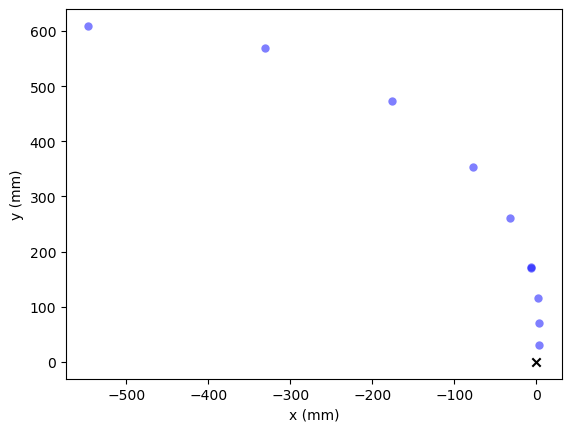

In [4]:
track = tracks[track_keys[2]]
utils.plot_track(track, coords = 'xy', alpha = 0.5, c = 'blue', lw = 0)

### Formatting src and trg sequences

The src and trg sequence follow a specific order. For the src sequence, the hits of both tracks are sorted based on their distance from their distance from the detector center. The target sequence starts with the SOS token and then is followed by the track which starts closest to the origin. This is then followed by the SEP token, the second track, and then another SEP token. 

In [46]:
key_idx1 = 9
key_idx2 = 19

track1 = tracks[track_keys[key_idx1]]
track2 = tracks[track_keys[key_idx2]]

src, src_df = utils.get_src_seq(track1, track2)

src_df

,x,y,z,r,volume_id,layer_id,module_id,umid,particle_id,um_idx
0,7.10417,-31.3462,86.8376,92.594936,8,2,133,8_2_133,4508203832311808,132
1,-15.54800,28.9310,134.5310,138.482248,8,2,142,8_2_142,4510952628162561,141
2,-35.61810,62.5795,138.6090,156.196344,8,4,283,8_4_283,4510952628162561,506
3,-55.59250,102.5520,143.3030,184.778756,8,6,512,8_6_512,4510952628162561,1183
4,16.38150,-70.7241,188.6680,202.153076,8,4,298,8_4_298,4508203832311808,521
5,-76.31990,154.5910,149.1530,227.968686,8,8,767,8_8_767,4510952628162561,2166
6,-98.52820,241.9770,158.6000,305.638078,13,2,513,13_2_513,4510952628162561,3004
7,26.54740,-111.9630,295.5740,317.182073,8,6,587,8_6_587,4508203832311808,1258
8,27.06290,-113.9990,300.8720,322.880989,8,6,588,8_6_588,4508203832311808,1259
9,-105.95500,346.6000,168.2000,399.561337,13,4,717,13_4_717,4510952628162561,4048


In [47]:
trg_df = utils.get_trg_seq(track1, track2)
trg_df

,um_idx,umid,cx,cy,cz
0,14000,sos,0.000000e+00,0.0000,0.0
1,132,8_2_133,6.291660e+00,-31.6303,105.0
2,521,8_4_298,2.082790e+01,-68.6605,175.0
3,1258,8_6_587,2.086450e+01,-113.8540,315.0
4,1259,8_6_588,3.443600e+01,-110.5090,315.0
5,2436,8_8_1037,4.110250e+01,-166.7590,455.0
6,3143,13_2_652,6.104600e+01,-254.2750,618.0
7,4412,13_4_1081,9.924550e+01,-344.4890,927.0
8,14001,sep,0.000000e+00,0.0000,0.0
9,141,8_2_142,-1.791710e+01,26.8149,105.0


### Model Predictions

In [49]:
device = 'cuda'
model = utils.load_model(device = device)
pred_um_idxs = utils.greedy_decode(src, src_df.um_idx, model, device = device)

Now we'll take a look at the predicted sequence and compare it with the target sequence

In [58]:
print("Predicted Sequence:")
print(pred_um_idxs)
print("Target Sequence:")
print(np.array(trg_df["um_idx"]))

Predicted Sequence:
[14000   132   141   506  1183  2166  3004  4048  5504  7446  9814 12886
 12733 12885 14001   521  1259  1258  2436  3143  4412 14001]
Target Sequence:
[14000   132   521  1258  1259  2436  3143  4412 14001   141   506  1183
  2166  3004  4048  5504  7446  9814 12886 12885 12733 14001]


Let's visualize these predictions. Modules are represented by dots. Lines represent what track each module belongs to according to the ground truth data. The color of the dot shows how the model groups the modules into tracks 

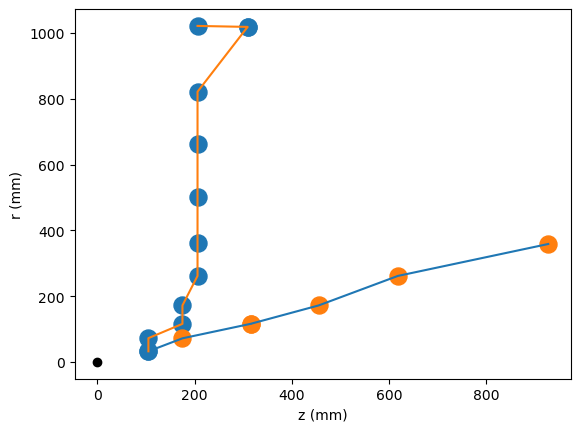

In [60]:
utils.visualize_results(pred_um_idxs, trg_df["um_idx"], mode='zr')

### Model Performance

Let's take a look at the model's performance on a larger dataset of track pairs. The file "Low pT results.csv" contains meta data information about each track and whether the model was able to correctly reconstruct it. In total, over 67k tracks were used in this dataset

In [10]:
df = pd.read_csv("./Low pT results.csv")
print("Number of tracks:", df.shape[0])
df.head()

Number of tracks: 67317


,Event Number,Track ID,pT (GeV),Num Hits,Matched
0,1110,4504149383184384,1.065266,8,1.0
1,1110,4504630419521536,0.319190,10,1.0
2,1110,4505661211672576,0.318228,11,1.0
3,1110,4506485845393408,0.635385,9,1.0
4,1110,4507104320684032,1.232096,9,1.0


#### Performance vs pT 

Now we will investigate how our model performs as a function of a track's pT

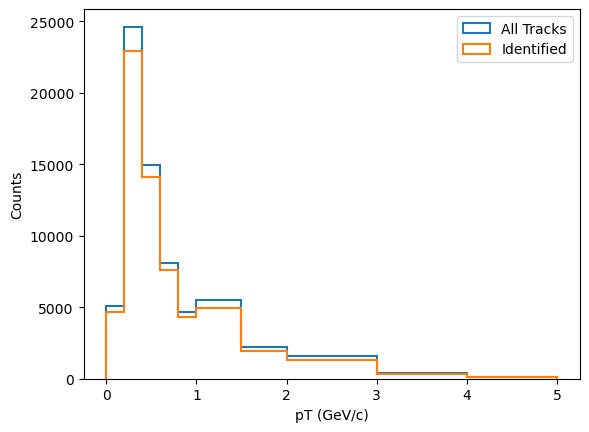

In [13]:
pTs = np.array(df["pT (GeV)"])
matched = np.array(df["Matched"]).astype(bool)

bins = np.array([0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.5, 2, 3, 4, 5])
bin_widths = (bins[1:] - bins[:-1]) / 2
bin_centers = bins[:-1] + bin_widths

all_count, _, _ = plt.hist(pTs, bins = bins, histtype = 'step', lw=1.5, label = "All Tracks")
identified_count, _ , _ = plt.hist(pTs[matched], bins = bins, histtype = 'step', lw=1.5, label = "Identified")

plt.xlabel("pT (GeV/c)")
plt.ylabel("Counts")
plt.legend()
plt.show()


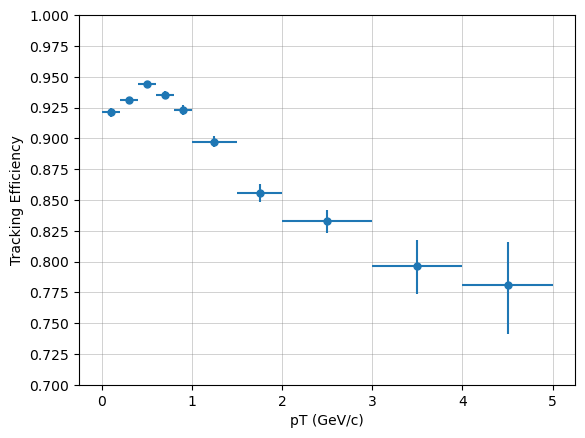

In [16]:
ratio, err = utils.get_ratio(identified_count, all_count)
plt.errorbar(bin_centers, ratio, fmt='o', yerr = err, xerr = bin_widths, ms = 5)

plt.xlabel("pT (GeV/c)")
plt.ylabel("Tracking Efficiency")

plt.ylim(0.7, 1.0)
plt.yticks(np.arange(13)/40 + 0.7, )

plt.grid(color = 'gray', linewidth = 0.5, alpha = 0.5)

plt.show()

#### Performance vs Track Length 

Next we will investigate how our model performs as a function of a track's length

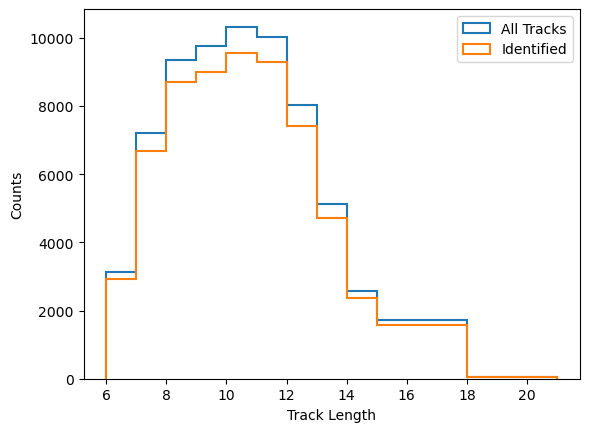

In [20]:
track_lens = np.array(df["Num Hits"])
matched = np.array(df["Matched"]).astype(bool)

bins = np.array([6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 18, 21])

bin_widths = (bins[1:] - bins[:-1]) / 2
bin_centers = bins[:-1] + bin_widths

all_count, _, _ = plt.hist(track_lens, bins = bins, histtype = 'step', lw=1.5, label = "All Tracks")
identified_count, _ , _ = plt.hist(track_lens[matched], bins = bins, histtype = 'step', lw=1.5, label = "Identified")

plt.xlabel("Track Length")
plt.ylabel("Counts")
plt.legend()
plt.show()


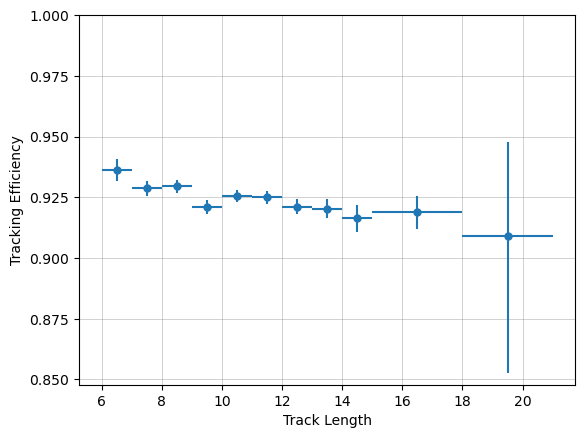

In [22]:
ratio, err = utils.get_ratio(identified_count, all_count)
plt.errorbar(bin_centers, ratio, fmt='o', yerr = err, xerr = bin_widths, ms = 5)

plt.xlabel("Track Length")
plt.ylabel("Tracking Efficiency")


plt.yticks(np.arange(7)/40 + 0.85, )

plt.grid(color = 'gray', linewidth = 0.5, alpha = 0.5)

plt.show()